# Time Series vs Supervised Learning

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


# Zadanie
Wczytaj dane "Monthly Car Sales Dataset", które pisują liczbę sprzedanych samochodów w Quebec, Kanada w latach 1960 i 1968.

In [3]:
series_row = pd.read_csv('.\monthly-car-sales-in-quebec-1960.csv', index_col = 'Month', squeeze = True, parse_dates=['Month'])
print(series_row.head(5))

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Monthly car sales in Quebec 1960-1968, dtype: int64


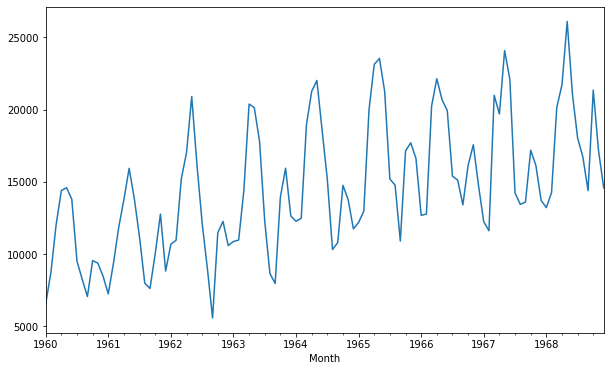

In [4]:
plt.figure(figsize=(10,6));
series_row.plot()
plt.show()

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
series_row_np = series_row.values
test_series = series_row.values[-20:]
series = series_row.values[:-20]

In [7]:
print(test_series.shape)
print(series.shape)

(20,)
(88,)


In [8]:
df = pd.DataFrame()
df['t'] = [x for x in series]
dataframe = series_to_supervised(df, 15)
dataframe.head()

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
15,6550.0,8728.0,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784
16,8728.0,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784.0,15926
17,12026.0,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784.0,15926.0,13821
18,14395.0,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784.0,15926.0,13821.0,11143
19,14587.0,13791.0,9498.0,8251.0,7049.0,9545.0,9364.0,8456.0,7237.0,9374.0,11837.0,13784.0,15926.0,13821.0,11143.0,7975


# Zadanie
Proszę wybrać optymalną metodę regresji do powyższych danych.

  * prosze podzielić zbiór danych na czść treningową i testową
  * proszę za pomoca cross validat-cji dobrać optymalne parametry
  * proszę wypisać zbiorcza tabelę z wynikami względem miar
    * explained_variance_score
    * mean_absolute_error
    * mean_squared_error
    * median_absolute_error
    * r2
  * Proszę użyć  
    * ElasticNet sklearn.linear_model.ElasticNet
    * Lasso sklearn.linear_model.Lasso
    * Ridge sklearn.linear_model.Ridge
    * LR sklearn.linear_model.LinearRegression
    * SVR sklearn.svm.SVR
    * RFR sklearn.ensemble.RandomForestRegressor
    * MLP_R sklearn.neural_network.MLPRegressor 

In [9]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:
seed=123
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=4, random_state=seed)

In [39]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1., 2., 3.]},
                    cv=kfold,
                    refit=True)
grid_1.fit(X_train, y_train)
print(grid_1.best_params_)
grid_1.best_estimator_


{'elasticnet__alpha': 3.0, 'polynomialfeatures__degree': 1}


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('elasticnet', ElasticNet(alpha=3.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])

In [40]:
from sklearn import  metrics


models = []
models.append(('ElasticNet', grid_1.best_estimator_))
# models.append(('Lasso', grid_2.best_estimator_))
# models.append(('Ridge', grid_3.best_estimator_))
# models.append(('LR', grid_4.best_estimator_))
# models.append(('SVR', grid_5.best_estimator_))
# models.append(('RFR', grid_6.best_estimator_))
# models.append(('MLP_R', grid_7.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

ElasticNet
R^2: 0.659190293506783
Explained variance score: 0.6594268037959594
Median absolute error: 1892.123080334517
Mean squared error: 4185332.616256864
Mean absolute errors: 1762.4201093450788


In [41]:
import pandas as pd
d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['ElasticNet'])
df

,Method,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2
0,ElasticNet,0.659427,1762.420109,4.185333e+06,1892.12308,0.65919


In [42]:
train = series
test = test_series
series_row.shape[0]

108

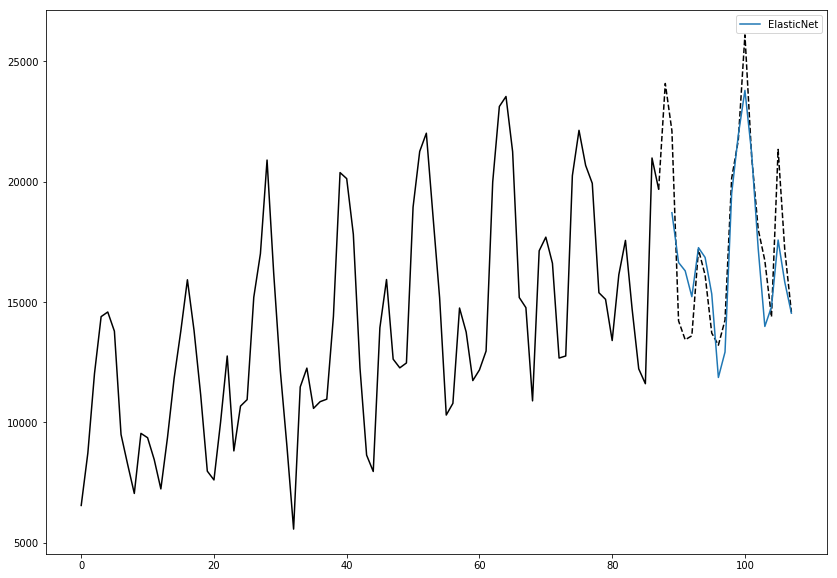

In [43]:
size=15

plt.figure(figsize=(14,10))
plt.plot(series,'k-')
data = np.zeros(series_row_np.shape[0], dtype=float)
data.fill(np.nan)
data[-21:] = series_row.values[-21:]
plt.plot(data, 'k--')

all_data = []
for name, model in models: 
    data = np.zeros(series_row_np.shape[0], dtype=float)
    data.fill(np.nan)
    for i in range(1,20):
        point = np.array([series_row_np[ (series_row_np.shape[0]-((size+1*i))):(series_row_np.shape[0]-(1*i))]])
        pre=model.predict(point)
        
        data[-i]=pre
    all_data.append(data)
    plt.plot( data , label=name)
    plt.legend(loc='best')
plt.show()